In [1]:
# Standard Libraries
import os
import random
import warnings

# Data Manipulation
import numpy as np
import pandas as pd
from collections import Counter

# Machine Learning Libraries
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import class_weight

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import imageio
import skimage
import skimage.io
import skimage.transform
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    MaxPool2D,
    Dropout,
    BatchNormalization,
    LeakyReLU,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    Callback,
    EarlyStopping,
    ReduceLROnPlateau,
)
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetV2L, DenseNet201, EfficientNetB5
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Recall

import itertools

# set cuda lib path
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/opt/cuda"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

2023-10-08 15:50:24.397383: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-08 15:50:24.419482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9241] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 15:50:24.419506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 15:50:24.420165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1516] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 15:50:24.423978: I tensorflow/core/platform/cpu_feature_guar

In [2]:
TRAIN_FILE = "./data/bees_train.csv"
TEST_FILE = "./data/bees_test.csv"
IMG_FOLDER = "./data/imgs/"

In [3]:
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)

CLASS_COUNT = len(train_df["subspecies"].unique())

In [4]:
print(train_df.head())

   id             datetime          file             location  zip code  \
0   0  2018-08-06 14:48:00   020_011.png    Saratoga, CA, USA     95070   
1   1  2018-08-21 09:00:00   032_507.png  Des Moines, IA, USA     50315   
2   2  2018-08-21 09:00:00   032_612.png  Des Moines, IA, USA     50315   
3   3  2018-08-17 17:50:00   030_773.png       Alvin, TX, USA     77511   
4   4  2018-08-06 13:19:00  015_1052.png    Saratoga, CA, USA     95070   

          subspecies        health  pollen_carrying   caste  
0  Italian honey bee       healthy            False  worker  
1  Russian honey bee       healthy            False  worker  
2  Russian honey bee       healthy            False  worker  
3  Italian honey bee  ant problems            False  worker  
4  Italian honey bee       healthy            False  worker  


In [5]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3465 entries, 0 to 3464
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               3465 non-null   int64 
 1   datetime         3465 non-null   object
 2   file             3465 non-null   object
 3   location         3465 non-null   object
 4   zip code         3465 non-null   int64 
 5   subspecies       3465 non-null   object
 6   health           3465 non-null   object
 7   pollen_carrying  3465 non-null   bool  
 8   caste            3465 non-null   object
dtypes: bool(1), int64(2), object(6)
memory usage: 220.1+ KB
None


In [6]:
print(train_df["subspecies"].value_counts())

subspecies
Italian honey bee        2010
Russian honey bee         360
Carniolan honey bee       344
1 Mixed local stock 2     301
-1                        282
VSH Italian honey bee     146
Western honey bee          22
Name: count, dtype: int64


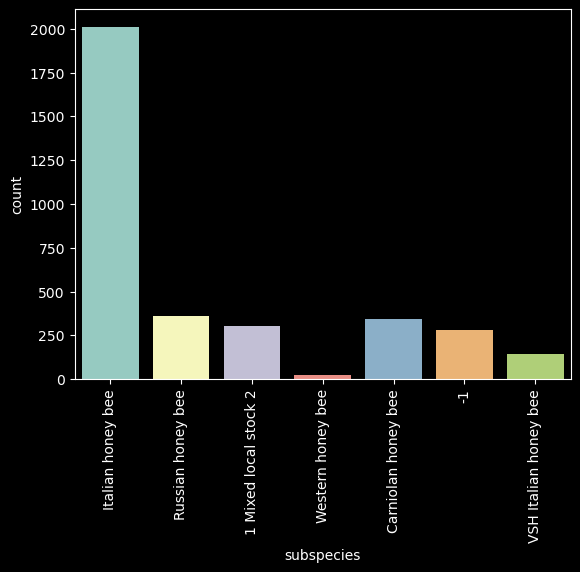

In [7]:
sns.countplot(data=train_df, x="subspecies")
plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
plt.show()

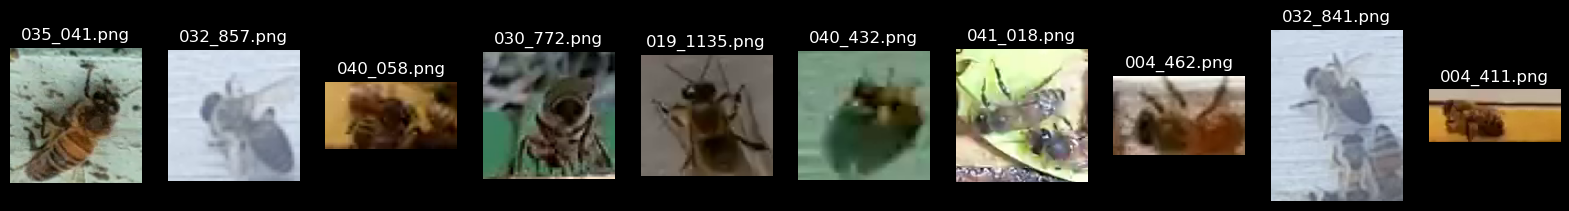

In [8]:
# List all files in the folder
all_files = os.listdir(IMG_FOLDER)

# Randomly select 10 image files
random_files = random.sample(all_files, 10)

# Create a figure and multiple subplots
fig, axes = plt.subplots(1, len(random_files), figsize=(20, 5))

for ax, image_file in zip(axes, random_files):
    # Create the full image path
    full_image_path = os.path.join(IMG_FOLDER, image_file)

    # Open the image using PIL
    image = Image.open(full_image_path)

    # Display the image in the corresponding subplot
    ax.imshow(image)
    ax.set_title(image_file)
    ax.axis("off")

plt.show()

In [9]:
# List all files in the folder
all_files = os.listdir(IMG_FOLDER)

# Initialize a list to store dimensions
image_dimensions = []

# Loop through each file to get its dimensions
for image_file in all_files:
    # Create the full image path
    full_image_path = os.path.join(IMG_FOLDER, image_file)

    # Open the image using PIL
    with Image.open(full_image_path) as img:
        # Get dimensions
        width, height = img.size
        image_dimensions.append((width, height))

widths = [dim[0] for dim in image_dimensions]
heights = [dim[1] for dim in image_dimensions]

print(f"Mean Width: {np.mean(widths):.2f}, Mean Height: {np.mean(heights):.2f}")
print(f"Median Width: {np.median(widths):.2f}, Median Height: {np.median(heights):.2f}")
print(f"Std Dev Width: {np.std(widths):.2f}, Std Dev Height: {np.std(heights):.2f}")

Mean Width: 74.42, Mean Height: 72.01
Median Width: 62.00, Median Height: 61.00
Std Dev Width: 41.21, Std Dev Height: 40.46


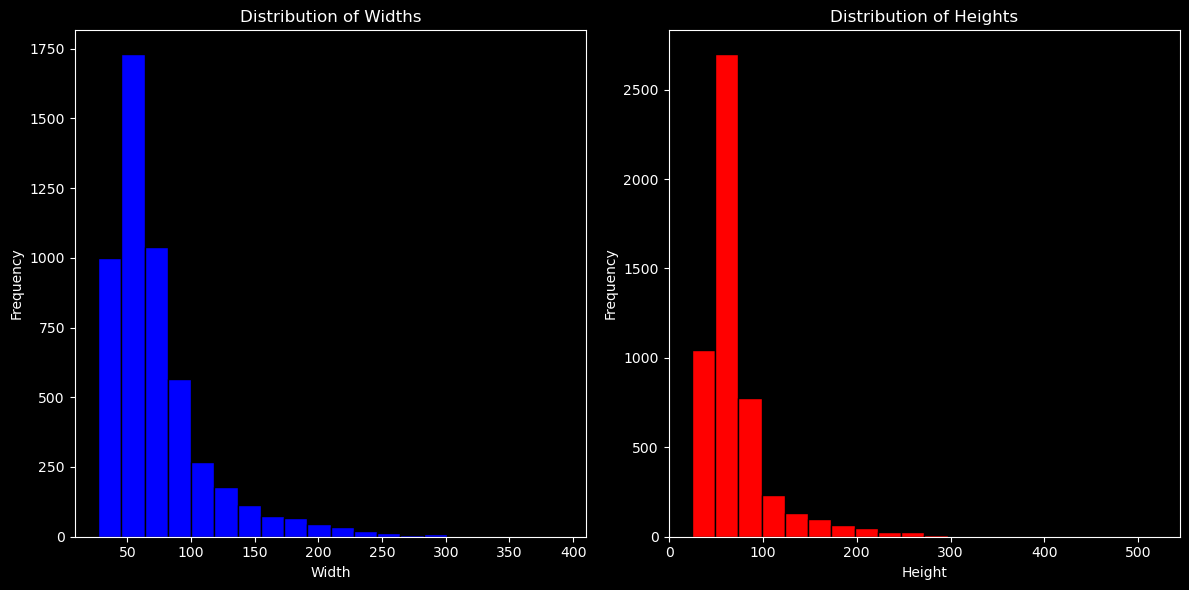

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color="blue", edgecolor="black")
plt.title("Distribution of Widths")
plt.xlabel("Width")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color="red", edgecolor="black")
plt.title("Distribution of Heights")
plt.xlabel("Height")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [11]:
print(f"25th percentile of widths: {np.percentile(widths, 25)}")
print(f"75th percentile of widths: {np.percentile(widths, 75)}")
print(f"25th percentile of heights: {np.percentile(heights, 25)}")
print(f"75th percentile of heights: {np.percentile(heights, 75)}")

25th percentile of widths: 48.0
75th percentile of widths: 84.0
25th percentile of heights: 51.0
75th percentile of heights: 76.0


## Challenges in the Dataset

### 1. Varying Image Sizes

#### Problem:
The dataset contains images of varying dimensions, making it difficult to feed them into a machine learning model that expects a fixed-size input.

#### Solution Ideas:
- **Resizing**: All images could be resized to a standard dimension before feeding them into the model.
- **Padding**: Add padding to the images to make them all the same size, filling the extra space with a constant value (e.g., zero).
- **Data Augmentation**: Use techniques like cropping to generate multiple fixed-size pieces from each original image, effectively increasing the dataset size.

---

### 2. Class Imbalance

#### Problem:
The dataset suffers from class imbalance, with one class having a majority of examples and another having very few. This could lead to a biased model that performs poorly on under-represented classes.

#### Solution Ideas:
- **Resampling**: 
  - **Oversampling**: Duplicate examples from the minority class or generate synthetic examples.
  - **Undersampling**: Reduce the number of examples from the majority class.
- **Class Weights**: Use weighted loss functions to give higher importance to under-represented classes during training.
- **Cost-sensitive Learning**: Modify the learning algorithm to be sensitive to the class imbalance.

---

By addressing these challenges, we aim to build a more robust and fair classification model.


In [12]:
from tensorflow.keras import backend as K
import gc


def get_image_train_data_generator(df, batch_size=32, img_size=32):
    # Initialize data augmentation
    train_datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1.0 / 255,
    )

    # Create the training data generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=IMG_FOLDER,
        x_col="file",
        y_col="subspecies",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    return train_generator


def get_image_data_generator(df, batch_size=32, img_size=32):
    train_dataframe, val_dataframe = train_test_split(
        df, test_size=0.10, shuffle=True, stratify=df["subspecies"]
    )
    while len(train_dataframe["subspecies"].unique()) != len(
        val_dataframe["subspecies"].unique()
    ):
        train_dataframe, val_dataframe = train_test_split(
            df, test_size=0.10, shuffle=True, stratify=df["subspecies"]
        )

    # Create the training data generator
    train_generator = get_image_train_data_generator(
        train_dataframe, batch_size, img_size
    )

    # Create the validation data generator
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_dataframe,
        directory=IMG_FOLDER,
        x_col="file",
        y_col="subspecies",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    return train_generator, val_generator, train_dataframe, val_dataframe


def macro_average_recall(y_true, y_pred):
    y_pred = K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

    # Calculate true positives, false positives, and false negatives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall_per_class = true_positives / (possible_positives + K.epsilon())

    # Calculate macro average recall
    macro_average_recall = K.mean(recall_per_class)
    
    return macro_average_recall


def evaluate_model(model, val_datagen):
    loops = 5
    loss_avg = 0
    macro_avg_recall_avg = 0
    for i in range(loops):
        loss, macro_avg_recall = model.evaluate(val_datagen)
        loss_avg += loss
        macro_avg_recall_avg += macro_avg_recall
    loss_avg /= loops
    macro_avg_recall_avg /= loops
    print(f"Loss: {loss_avg:.4f}, Macro Average Recall: {macro_avg_recall_avg:.4f}")
    return macro_avg_recall_avg


def train_model(
    model,
    class_weights,
    train_generator,
    train_dataframe,
    val_generator=None,
    val_dataframe=None,
    epochs=100,
    batch_size=32,
    do_early_stopping=True,
):
    callbacks = []
    if do_early_stopping:
        early_stopping = EarlyStopping(
            monitor="val_loss", patience=15, verbose=1, mode="min"
        )
        callbacks.append(early_stopping)

    model.fit(
        train_generator,
        steps_per_epoch=len(train_dataframe) // batch_size,
        validation_data=val_generator,
        validation_steps=0
        if val_dataframe is None
        else len(val_dataframe) // batch_size,
        class_weight=class_weights,
        epochs=epochs,
        callbacks=callbacks,
    )
    if do_early_stopping:
        stopped_epoch = early_stopping.stopped_epoch
        return stopped_epoch
    else:
        return epochs


def clear_session(
    model, train_generator, val_generator, train_dataframe, val_dataframe
):
    print("Clearing session...")
    K.clear_session()
    del train_generator, val_generator
    del train_dataframe, val_dataframe
    del model
    gc.collect()


def create_model(
    base_model,
    optimizer="Adam",
    trainable_base_model=False,
    learning_rate=0.001,
    dropout=0.5,
):
    if optimizer == "Adam":
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)

    baseModel = base_model

    # Freeze the base model
    if not trainable_base_model:
        for layer in baseModel.layers:
            layer.trainable = False

    # Create the head of the model
    headModel = baseModel.output
    headModel = layers.Flatten(name="flatten")(headModel)
    headModel = layers.Dense(512, activation="relu")(headModel)
    headModel = layers.Dropout(dropout)(headModel)
    headModel = layers.Dense(CLASS_COUNT, activation="softmax")(headModel)

    # Combine base model and head model
    model = Model(inputs=baseModel.input, outputs=headModel)

    model.compile(
        loss="categorical_crossentropy", optimizer=opt, metrics=[macro_average_recall]
    )
    return model


def train_and_evaluate_model(
    base_model,
    trainable_base_model,
    original_train_dataframe,
    folds,
    class_weights,
    img_size=32,
    epoch=100,
    batch_size=32,
    optimizer="Adam",
    learning_rate=0.001,
    dropout=0.5,
):
    stopped_epoch_avg = 0
    recall_avg = 0

    # iterate over the folds
    for i in range(folds):
        print(f"Fold: {i+1}/{folds}")
        (
            train_generator,
            val_generator,
            train_dataframe,
            val_dataframe,
        ) = get_image_data_generator(
            original_train_dataframe,
            batch_size,
            img_size,
        )
        model = create_model(
            base_model,
            optimizer,
            trainable_base_model,
            learning_rate,
            dropout,
        )
        stopped_epoch = train_model(
            model,
            class_weights,
            train_generator,
            train_dataframe,
            val_generator,
            val_dataframe,
            epoch,
            batch_size,
            True,
        )
        stopped_epoch_avg += stopped_epoch if stopped_epoch > 0 else epoch

        recall_avg += evaluate_model(model, val_generator)

        clear_session(
            model, train_generator, val_generator, train_dataframe, val_dataframe
        )

    recall_avg /= folds
    stopped_epoch_avg = stopped_epoch_avg // folds

    # train on the whole dataset
    print("Training on the whole dataset...")
    train_generator = get_image_train_data_generator(
        original_train_dataframe, batch_size, img_size
    )
    model = create_model(
        base_model, optimizer, trainable_base_model, learning_rate, dropout
    )
    train_model(
        model,
        class_weights,
        train_generator,
        original_train_dataframe,
        None,
        None,
        stopped_epoch_avg,
        batch_size,
        False,
    )

    return model, recall_avg


y = np.array(train_df["subspecies"].astype("category").cat.codes)
class_weights = class_weight.compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [14]:
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCH = 200
LEARNING_RATE = 1e-4
DROPOUT = 0.5
FOLDS = 3
OPTIMIZER = "Adam"


In [15]:
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model1, recall1 = train_and_evaluate_model(
    baseModel,
    True,
    train_df,
    FOLDS,
    class_weights_dict,
    img_size=IMG_SIZE,
    epoch=EPOCH,
    batch_size=BATCH_SIZE,
    optimizer=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    dropout=DROPOUT,
)
print(f"AVG Macro Average Recall: {recall1:.4f}")

2023-10-08 15:50:25.708412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:913] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-08 15:50:25.723743: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:913] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-08 15:50:25.723892: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:913] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Fold: 1/2
Found 3118 validated image filenames belonging to 7 classes.
Found 347 validated image filenames belonging to 7 classes.
Epoch 1/200


2023-10-08 15:50:27.053808: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:440] Loaded cuDNN version 8902
2023-10-08 15:50:27.646935: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f61bc019070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 15:50:27.646950: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-10-08 15:50:27.650510: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1696791027.706574 2137954 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 [==============================] - 7s 29ms/step - loss: 1.7209 - macro_average_recall: 0.3331 - val_loss: 1.7690 - val_macro_average_recall: 0.3880
Epoch 2/200
97/97 [==============================] - 2s 21ms/step - loss: 0.9936 - macro_average_recall: 0.5190 - val_loss: 0.9426 - val_macro_average_recall: 0.5833
Epoch 3/200
97/97 [==============================] - 2s 21ms/step - loss: 1.0962 - macro_average_recall: 0.5197 - val_loss: 0.8732 - val_macro_average_recall: 0.5845
Epoch 4/200
97/97 [==============================] - 2s 21ms/step - loss: 0.4533 - macro_average_recall: 0.6816 - val_loss: 0.5020 - val_macro_average_recall: 0.7171
Epoch 5/200
97/97 [==============================] - 2s 21ms/step - loss: 0.7756 - macro_average_recall: 0.6361 - val_loss: 0.7646 - val_macro_average_recall: 0.7292
Epoch 6/200
97/97 [==============================] - 2s 21ms/step - loss: 0.3588 - macro_average_recall: 0.7175 - val_loss: 0.4315 - val_macro_average_recall: 0.7778
Epoch 7/200
97/9

In [16]:
baseModel = ResNet50(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
model2, recall2 = train_and_evaluate_model(
    baseModel,
    True,
    train_df,
    FOLDS,
    class_weights_dict,
    img_size=IMG_SIZE,
    epoch=EPOCH,
    batch_size=BATCH_SIZE,
    optimizer=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    dropout=DROPOUT,
)
print(f"AVG Macro Average Recall: {recall2:.4f}")

Fold: 1/2
Found 3118 validated image filenames belonging to 7 classes.
Found 347 validated image filenames belonging to 7 classes.
Epoch 1/200
97/97 [==============================] - 20s 49ms/step - loss: 1.4062 - macro_average_recall: 0.5124 - val_loss: 37.7683 - val_macro_average_recall: 0.1429
Epoch 2/200
97/97 [==============================] - 2s 22ms/step - loss: 0.4725 - macro_average_recall: 0.7005 - val_loss: 91.6908 - val_macro_average_recall: 0.1429
Epoch 3/200
97/97 [==============================] - 2s 22ms/step - loss: 0.3752 - macro_average_recall: 0.7176 - val_loss: 36.1544 - val_macro_average_recall: 0.1429
Epoch 4/200
97/97 [==============================] - 2s 22ms/step - loss: 0.2509 - macro_average_recall: 0.7603 - val_loss: 77.0450 - val_macro_average_recall: 0.1429
Epoch 5/200
97/97 [==============================] - 2s 22ms/step - loss: 0.1871 - macro_average_recall: 0.7657 - val_loss: 51.1162 - val_macro_average_recall: 0.1429
Epoch 6/200
97/97 [==============

In [17]:
baseModel = EfficientNetB5(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
model3, recall3 = train_and_evaluate_model(
    baseModel,
    True,
    train_df,
    FOLDS,
    class_weights_dict,
    img_size=IMG_SIZE,
    epoch=EPOCH,
    batch_size=BATCH_SIZE,
    optimizer=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    dropout=DROPOUT,
)
print(f"AVG Macro Average Recall: {recall3:.4f}")

Fold: 1/2
Found 3118 validated image filenames belonging to 7 classes.
Found 347 validated image filenames belonging to 7 classes.
Epoch 1/200


2023-10-08 16:01:35.842500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 [==============================] - 42s 65ms/step - loss: 1.6896 - macro_average_recall: 0.3487 - val_loss: 4.2511 - val_macro_average_recall: 0.0286
Epoch 2/200
97/97 [==============================] - 5s 48ms/step - loss: 1.0523 - macro_average_recall: 0.5019 - val_loss: 3.1507 - val_macro_average_recall: 0.0814
Epoch 3/200
97/97 [==============================] - 5s 49ms/step - loss: 0.8463 - macro_average_recall: 0.5816 - val_loss: 2.7287 - val_macro_average_recall: 0.0214
Epoch 4/200
97/97 [==============================] - 5s 49ms/step - loss: 0.6870 - macro_average_recall: 0.6353 - val_loss: 2.8264 - val_macro_average_recall: 0.0761
Epoch 5/200
97/97 [==============================] - 5s 48ms/step - loss: 0.6392 - macro_average_recall: 0.6381 - val_loss: 2.1567 - val_macro_average_recall: 0.2903
Epoch 6/200
97/97 [==============================] - 5s 49ms/step - loss: 0.5035 - macro_average_recall: 0.6686 - val_loss: 1.8035 - val_macro_average_recall: 0.3234
Epoch 7/200
97/

2023-10-08 16:06:08.072756: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 [==============================] - 42s 66ms/step - loss: 0.2716 - macro_average_recall: 0.7648 - val_loss: 2.7341 - val_macro_average_recall: 0.3697
Epoch 2/200
97/97 [==============================] - 5s 50ms/step - loss: 0.1054 - macro_average_recall: 0.7916 - val_loss: 1.0328 - val_macro_average_recall: 0.4719
Epoch 3/200
97/97 [==============================] - 5s 50ms/step - loss: 0.1156 - macro_average_recall: 0.7870 - val_loss: 5.3459 - val_macro_average_recall: 0.2006
Epoch 4/200
97/97 [==============================] - 5s 51ms/step - loss: 0.0923 - macro_average_recall: 0.7988 - val_loss: 1.4158 - val_macro_average_recall: 0.4554
Epoch 5/200
97/97 [==============================] - 5s 51ms/step - loss: 0.0991 - macro_average_recall: 0.8068 - val_loss: 2.2473 - val_macro_average_recall: 0.3835
Epoch 6/200
97/97 [==============================] - 5s 51ms/step - loss: 0.1097 - macro_average_recall: 0.7922 - val_loss: 1.4118 - val_macro_average_recall: 0.3636
Epoch 7/200
97/

2023-10-08 16:08:09.780741: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


108/108 [==============================] - 40s 49ms/step - loss: 0.1996 - macro_average_recall: 0.7766
Epoch 2/31
108/108 [==============================] - 5s 49ms/step - loss: 0.1051 - macro_average_recall: 0.7920
Epoch 3/31
108/108 [==============================] - 5s 48ms/step - loss: 0.0688 - macro_average_recall: 0.8040
Epoch 4/31
108/108 [==============================] - 5s 48ms/step - loss: 0.0711 - macro_average_recall: 0.7899
Epoch 5/31
108/108 [==============================] - 5s 49ms/step - loss: 0.1320 - macro_average_recall: 0.7901
Epoch 6/31
108/108 [==============================] - 5s 49ms/step - loss: 0.1004 - macro_average_recall: 0.7995
Epoch 7/31
108/108 [==============================] - 5s 49ms/step - loss: 0.0811 - macro_average_recall: 0.8113
Epoch 8/31
108/108 [==============================] - 5s 48ms/step - loss: 0.0703 - macro_average_recall: 0.7967
Epoch 9/31
108/108 [==============================] - 5s 48ms/step - loss: 0.0757 - macro_average_recall: 

In [18]:
baseModel = DenseNet201(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
model4, recall4 = train_and_evaluate_model(
    baseModel,
    True,
    train_df,
    FOLDS,
    class_weights_dict,
    img_size=IMG_SIZE,
    epoch=EPOCH,
    batch_size=BATCH_SIZE,
    optimizer=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    dropout=DROPOUT,
)
print(f"AVG Macro Average Recall: {recall4:.4f}")

Fold: 1/2
Found 3118 validated image filenames belonging to 7 classes.
Found 347 validated image filenames belonging to 7 classes.
Epoch 1/200
97/97 [==============================] - 70s 168ms/step - loss: 1.3509 - macro_average_recall: 0.4933 - val_loss: 1.1475 - val_macro_average_recall: 0.4369
Epoch 2/200
97/97 [==============================] - 5s 53ms/step - loss: 0.4411 - macro_average_recall: 0.6945 - val_loss: 0.4586 - val_macro_average_recall: 0.7021
Epoch 3/200
97/97 [==============================] - 5s 51ms/step - loss: 0.2854 - macro_average_recall: 0.7482 - val_loss: 0.2451 - val_macro_average_recall: 0.7240
Epoch 4/200
97/97 [==============================] - 5s 51ms/step - loss: 0.2302 - macro_average_recall: 0.7622 - val_loss: 0.2085 - val_macro_average_recall: 0.8340
Epoch 5/200
97/97 [==============================] - 5s 51ms/step - loss: 0.2004 - macro_average_recall: 0.7651 - val_loss: 0.2223 - val_macro_average_recall: 0.8149
Epoch 6/200
97/97 [==================

In [19]:
models = [model1, model2, model3, model4]
recalls = [recall1, recall2, recall3, recall4]
best_model = models[np.argmax(recalls)]

In [22]:
best_model = models[1]

In [23]:
train_generator = get_image_train_data_generator(train_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMG_FOLDER,
    x_col='file',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

predictions = best_model.predict(test_generator, steps=len(test_generator), verbose=1)

predicted_class_indices = np.argmax(predictions, axis=1)

class_indices = train_generator.class_indices  
class_indices = {v: k for k, v in class_indices.items()} 
predicted_class_names = [class_indices[i] for i in predicted_class_indices]

output_df = pd.DataFrame({'id': test_df['id'], 'expected': predicted_class_names})

output_df.to_csv('predictions.csv', index=False)


Found 3465 validated image filenames belonging to 7 classes.
Found 1707 validated image filenames.
54/54 [==============================] - 1s 14ms/step
